# Generate 3d Binary Choice data

In [1]:
import os
import numpy as np
from scipy.stats import multivariate_normal
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from plnn.models.algebraic_pl import AlgebraicPL
from plnn.pl import plot_phi

In [11]:
plt.rcParams['font.size'] = 10

In [12]:
seed = 42
rng = np.random.default_rng(seed=seed)
key = jrandom.PRNGKey(rng.integers(2**32))

In [13]:
OUTDIR = "out/syndata_bc_3d"
os.makedirs(OUTDIR, exist_ok=True)

In [14]:
SIGMA = 0.4

RHO = 3
ETA = 0.1

In [15]:
sf = 1/2.54
FIGSIZE = None

In [16]:
key, subkey = jrandom.split(key, 2)
model, _ = AlgebraicPL.make_model(
    key=subkey,
    dtype=jnp.float64,
    algebraic_phi_id="phi1",
    tilt_weights=[[1, 0],[0, 1]],
    tilt_bias=[0, 0],
    sigma_init=SIGMA,
    signal_type="sigmoid",
    nsigparams=4,
)

In [17]:
# Simulation parameters

ncells = 100
x0_val = (0.0, -0.5)
tfin = 6
burnin = 0.2
burnin_signal = (0, 1)
dtsave1 = 0.1
dtsave2 = 2.


# Signal profiles
rate1 = 1
rate2 = 1
rate3 = 1

sigparams1 = [
    [1.50, 0, -0.50, rate1], 
    [1.75, 1, -0.25, rate1],
]
sigparams2 = [
    [1.25, 0,  0.75, rate2], 
    [1.75, 1, -0.50, rate2],
]
sigparams3 = [
    [1.25, 0, -0.10, rate3], 
    [1.75, 1, -0.50, rate3],
]

SIGPARAMS_LIST = [
    sigparams1, 
    sigparams2, 
    sigparams3,
]

In [18]:
XS_RESULTS = []
for cond_idx, sigparams in enumerate(SIGPARAMS_LIST):
    sigparams = jnp.array(sigparams, dtype=jnp.float64)

    # Initial condition
    key, subkey = jrandom.split(key, 2)
    x0 = np.zeros([ncells, 2])
    x0[:] = x0_val

    # Simulate particles in the landscape
    key, subkey = jrandom.split(key, 2)
    ts_all, xys_all, sigs_all, ps_all = model.run_landscape_simulation(
        x0, tfin, [dtsave1, dtsave2], sigparams, subkey, 
        burnin=burnin
    )

    ts, ts_saved = ts_all
    xys, xys_saved = xys_all
    sigs, sigs_saved = sigs_all
    ps, ps_saved = ps_all

    zs_saved = np.sqrt(RHO**2 - xys_saved[...,0]**2 - xys_saved[...,1]**2)
    zs_saved += ETA * rng.standard_normal(zs_saved.shape)
    
    xyzs_saved = np.zeros(xys_saved.shape[0:-1] + (3,))
    xyzs_saved[...,0:2] = xys_saved
    xyzs_saved[...,-1] = zs_saved
    XS_RESULTS.append(xyzs_saved)

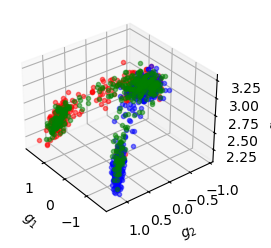

In [128]:
# %matplotlib widget
figsize = (8*sf, 6*sf)
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(32, 142)

colors = ['r', 'b', 'g']

legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for xyz in xyz_across_times:
        sc, = ax.plot(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            color=colors[cond_idx],
            alpha=0.5,
        )
    legend_handles.append(sc)
    legend_labels.append(f"Exp. {cond_idx+1}")

ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")
ax.set_zlabel("$g_3$")
# ax.legend(
    # legend_handles, legend_labels, 
    # bbox_to_anchor=(0.9, 1), loc='upper left',
    # fontsize='small',
# )

xlims = ax.get_xlim()
ylims = ax.get_ylim()
zlims = ax.get_zlim()

plt.savefig(f"{OUTDIR}/data_combined.pdf", bbox_inches='tight', pad_inches=0.2, transparent=True)

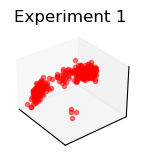

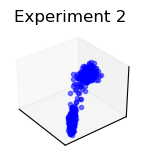

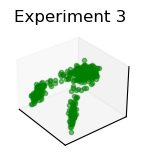

In [119]:
figsize = (1.5, 1.5)
colors = ['r', 'b', 'g']
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    fig = plt.figure(figsize=figsize, layout='constrained')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(32, 142)

    for xyz in xyz_across_times:
        ax.plot(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            color=colors[cond_idx],
            alpha=0.5,
        )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # ax.set_xlabel("$g_1$")
    # ax.set_ylabel("$g_2$")
    # ax.set_zlabel("$g_3$")
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_zlim(*zlims)
    ax.set_title(f"Experiment {cond_idx+1}")
    plt.savefig(f"{OUTDIR}/data_cond_{cond_idx+1}.pdf", bbox_inches='tight', pad_inches=0.3, transparent=True)
    


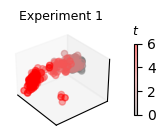

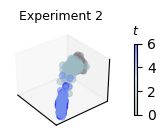

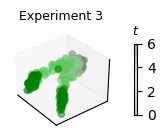

In [167]:
figsize = (2.5, 1.5)

from matplotlib.colors import LinearSegmentedColormap
reds = LinearSegmentedColormap.from_list(
    'custom_reds', [(0, 'grey'), (0.5, 'lightcoral'), (1, 'red')]
)
blues = LinearSegmentedColormap.from_list(
    'custom_blues', [(0, 'grey'), (0.5, 'lightblue'), (1, 'blue')]
)
greens = LinearSegmentedColormap.from_list(
    'custom_greens', [(0, 'grey'), (0.5, 'lightgreen'), (1, 'green')]
)

cmaps = [reds, blues, greens]

for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    fig = plt.figure(figsize=figsize, layout='tight')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(32, 142)

    for t, xyz in zip(ts_saved, xyz_across_times):

        sc = ax.scatter(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )

    # ax.set_xlabel("$g_1$")
    # ax.set_ylabel("$g_2$")
    # ax.set_zlabel("$g_3$")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])        
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.set_zlim(*zlims)
    ax.set_title(f"Experiment {cond_idx+1}", fontsize=9)
    
    cbar = fig.colorbar(sc, ax=ax, pad=0.1, orientation='vertical', shrink=0.7)
    cbar.ax.set_title("$t$", fontsize=9)
    cbar.ax.set_yticks(ts_saved) 

    plt.savefig(f"{OUTDIR}/data_tshaded_cond_{cond_idx+1}.pdf", bbox_inches='tight')

In [168]:
xdata_all = np.array(XS_RESULTS).reshape([-1, 3])

In [169]:
from sklearn.mixture import GaussianMixture

NCOMPS = 3

gmm = GaussianMixture(n_components=NCOMPS)
gmm.fit(xdata_all)

GaussianMixture(n_components=3)

In [170]:
CONTOUR_ALPHA = 1.0
CONTOUR_LEVELS = [0.95, 0.75, 0.5]  # plot level sets of GMMs at alpha level

COMPONENT_COLORS = [
    'purple', 'cyan', 'orange'
]

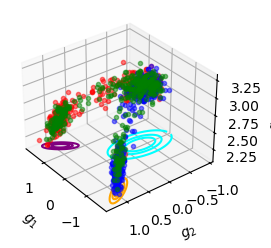

In [173]:
# %matplotlib widget
figsize = (8*sf, 6*sf)
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(32, 142)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )


colors = ['r', 'b', 'g']
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for xyz in xyz_across_times:
        sc, = ax.plot(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            color=colors[cond_idx],
            alpha=0.5,
            zorder=6,
        )
    legend_handles.append(sc)
    legend_labels.append(f"Exp. {cond_idx+1}")

ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")
ax.set_zlabel("$g_3$")
# ax.legend(legend_handles, legend_labels)

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/data_combined_clustered.pdf", bbox_inches='tight', pad_inches=0.2, transparent=True)

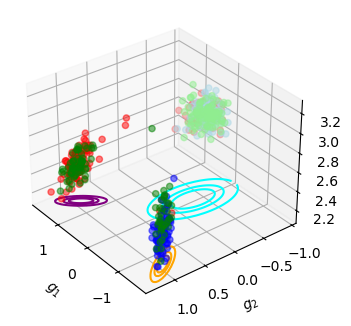

In [189]:
# %matplotlib widget
figsize = (10*sf, 8*sf)
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(32, 142)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

cmaps = [
    LinearSegmentedColormap.from_list(
        'custom_reds', [(0, 'lightcoral'), (1, 'red')]
    ),
    LinearSegmentedColormap.from_list(
        'custom_blues', [(0, 'lightblue'), (1, 'blue')]
    ),
    LinearSegmentedColormap.from_list(
        'custom_greens', [(0, 'lightgreen'), (1, 'green')]
    ),
]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip([ts_saved[0], ts_saved[-1]], 
                       [xyz_across_times[0], xyz_across_times[-1]]):
        sc = ax.scatter(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        legend_handles.append(sc)
        legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}"),

ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")
ax.set_zlabel("$g_3$")
# ax.legend(
#     legend_handles, legend_labels, 
#     bbox_to_anchor=(0.75, 1.2), loc='upper left',
#     fontsize='small',
# )

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)
plt.savefig(f"{OUTDIR}/data_endpoints_clustered.pdf", bbox_inches='tight', pad_inches=0.2, transparent=True)

In [190]:
# Apply PCA

from sklearn.decomposition import PCA

xs_endpoints = np.array([XS_RESULTS[0], XS_RESULTS[-1]])
xdata_endpoints = xs_endpoints.reshape([-1, 3])

mu_xdata_endpoints = xdata_endpoints.mean(axis=0)

pca = PCA(n_components=3)
pca.fit(xdata_endpoints)

xdata_endpoints_trans = pca.transform(xdata_endpoints)
uvw_endpoints = xdata_endpoints_trans.reshape(np.shape(xs_endpoints))

In [191]:
# Compute the plane

pc1 = pca.components_[0]
pc2 = pca.components_[1]

normal = np.cross(pc1, pc2)
d = np.dot(normal, mu_xdata_endpoints)
plane_eq = lambda x, y: (d - normal[0]*x - normal[1]*y) / normal[2]

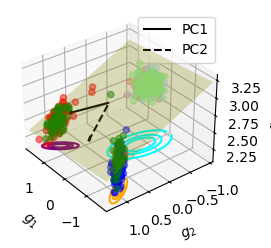

In [207]:
# Plot plane
figsize = (10*sf, 6*sf)
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(32, 142)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

cmaps = [
    LinearSegmentedColormap.from_list(
        'custom_reds', [(0, 'lightcoral'), (1, 'red')]
    ),
    LinearSegmentedColormap.from_list(
        'custom_blues', [(0, 'lightblue'), (1, 'blue')]
    ),
    LinearSegmentedColormap.from_list(
        'custom_greens', [(0, 'lightgreen'), (1, 'green')]
    ),
]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip([ts_saved[0], ts_saved[-1]], 
                       [xyz_across_times[0], xyz_across_times[-1]]):
        sc = ax.scatter(
            xyz[:,0], xyz[:,1], xyz[:,2], '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")

# Plot surface
xarr = np.linspace(*xlims, 100)
yarr = np.linspace(*ylims, 100)
xs, ys = np.meshgrid(xarr, yarr)
pos = np.dstack([xs, ys])
zs = plane_eq(xs.flatten(), ys.flatten()).reshape(xs.shape)

ax.plot_surface(
    xs, ys, zs, 
    rstride=100, 
    cstride=100,
    alpha=0.25, 
    color='y'
)

# Plot PC directions
ax.quiver(
    *mu_xdata_endpoints, *pc1,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='-',
    label="PC1",
)
ax.quiver(
    *mu_xdata_endpoints, *pc2,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='--',
    label="PC2",
)
ax.legend()

# Plot arrows
arrow1_start = [*mu_xdata_endpoints[0:2], plane_eq(*mu_xdata_endpoints[0:2])]
arrow2_start = [*mu_xdata_endpoints[0:2], plane_eq(*mu_xdata_endpoints[0:2])]

ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")
ax.set_zlabel("$g_3$")

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/data_endpoints_clustered_pca_plane.pdf", bbox_inches='tight', pad_inches=0.25, transparent=True)

In [202]:
# Transform all of the data and plot projection on the plane
xdata_trans = pca.transform(xdata_all)
uvw_all = xdata_trans.reshape(np.shape(XS_RESULTS))

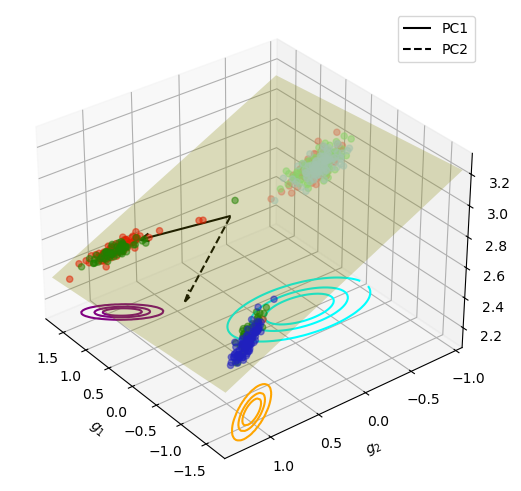

In [203]:
# %matplotlib widget
fig = plt.figure(figsize=FIGSIZE, layout='constrained')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(32, 142)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

cmaps = [
    LinearSegmentedColormap.from_list(
        'custom_reds', [(0, 'lightcoral'), (1, 'red')]
    ),
    LinearSegmentedColormap.from_list(
        'custom_blues', [(0, 'lightblue'), (1, 'blue')]
    ),
    LinearSegmentedColormap.from_list(
        'custom_greens', [(0, 'lightgreen'), (1, 'green')]
    ),
]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip([ts_saved[0], ts_saved[-1]], 
                       [xyz_across_times[0], xyz_across_times[-1]]):
        uv = pca.transform(xyz)[:,0:2]
        proj_xy = mu_xdata_endpoints[None,:] + uv @ np.array([pc1, pc2])
        z = plane_eq(proj_xy[:,0], proj_xy[:,1])
        sc = ax.scatter(
            proj_xy[:,0], proj_xy[:,1], z, '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")

# Plot surface
xarr = np.linspace(*xlims, 100)
yarr = np.linspace(*ylims, 100)
xs, ys = np.meshgrid(xarr, yarr)
pos = np.dstack([xs, ys])
zs = plane_eq(xs.flatten(), ys.flatten()).reshape(xs.shape)

# Plot PC directions
q1 = ax.quiver(
    *mu_xdata_endpoints, *pc1,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='-',
    label="PC1",
)
q2 = ax.quiver(
    *mu_xdata_endpoints, *pc2,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='--',
    label="PC2",
)

ax.plot_surface(
    xs, ys, zs, 
    rstride=100, 
    cstride=100,
    alpha=0.25, 
    color='y'
)

ax.legend()

ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")
ax.set_zlabel("$g_3$")

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/endpoint_data_projected_pca_plane.pdf")

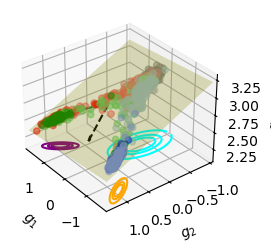

In [208]:
# %matplotlib widget
figsize = (10*sf, 6*sf)
fig = plt.figure(figsize=figsize, layout='constrained')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(32, 142)

for comp_idx in range(NCOMPS):
    mean = gmm.means_[comp_idx]
    cov = gmm.covariances_[comp_idx]
    mvn = multivariate_normal(mean=mean[0:2], cov=cov[0:2,0:2])
    xarr = np.linspace(*xlims, 100)
    yarr = np.linspace(*ylims, 100)
    xs, ys = np.meshgrid(xarr, yarr)
    pos = np.dstack([xs, ys])
    zs = mvn.pdf(pos)
    alpha_levels = np.array(CONTOUR_LEVELS)
    c = -2*np.log(1 - alpha_levels)
    levels = np.exp(-c/2) / (2*np.pi*np.sqrt(np.linalg.det(mvn.cov)))
    col = COMPONENT_COLORS[comp_idx]
    ax.contour(
        xs, ys, zs,
        levels=np.sort(levels),
        zdir='z',
        offset=zlims[0],
        colors=[col],
        alpha=CONTOUR_ALPHA,
    )

cmaps = [reds, blues, greens]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip(ts_saved, xyz_across_times):
        uv = pca.transform(xyz)[:,0:2]
        proj_xy = mu_xdata_endpoints[None,:] + uv @ np.array([pc1, pc2])
        z = plane_eq(proj_xy[:,0], proj_xy[:,1])
        sc = ax.scatter(
            proj_xy[:,0], proj_xy[:,1], z, '.', 
            c = t * np.ones(xyz.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")

# Plot surface
xarr = np.linspace(*xlims, 100)
yarr = np.linspace(*ylims, 100)
xs, ys = np.meshgrid(xarr, yarr)
pos = np.dstack([xs, ys])
zs = plane_eq(xs.flatten(), ys.flatten()).reshape(xs.shape)

# Plot PC directions
ax.quiver(
    *mu_xdata_endpoints, *pc1,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='-',
)
ax.quiver(
    *mu_xdata_endpoints, *pc2,
    color='k', alpha=1, lw=1.5, arrow_length_ratio=0.1, length=1,
    linestyle='--',
)

ax.plot_surface(
    xs, ys, zs, 
    rstride=100, 
    cstride=100,
    alpha=0.25, 
    color='y'
)

ax.set_xlabel("$g_1$")
ax.set_ylabel("$g_2$")
ax.set_zlabel("$g_3$")

ax.set_xlim(*xlims)
ax.set_ylim(*ylims)
ax.set_zlim(*zlims)

plt.savefig(f"{OUTDIR}/all_data_projected_pca_plane.pdf", bbox_inches='tight', pad_inches=0.25, transparent=True)

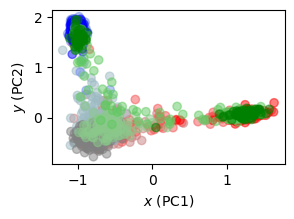

In [213]:
# %matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(3,2))

cmaps = [reds, blues, greens]
legend_handles = []
legend_labels = []
for cond_idx, xyz_across_times in enumerate(XS_RESULTS):
    for t, xyz in zip(ts_saved, xyz_across_times):
        uvw = pca.transform(xyz)
        sc = ax.scatter(
            uvw[:,0], uvw[:,1],
            c = t * np.ones(uvw.shape[0]),
            cmap=cmaps[cond_idx],
            vmin=ts_saved[0],
            vmax=ts_saved[-1],
            alpha=0.5,
        )
        # legend_handles.append(sc)
        # legend_labels.append(f"Exp. {cond_idx+1}, t={t:n}")


ax.set_xlabel("$x$ (PC1)")
ax.set_ylabel("$y$ (PC2)")

plt.savefig(f"{OUTDIR}/all_data_pc1_vs_pc2.pdf", bbox_inches='tight', transparent=True)